In [1]:
import scipy.stats as sps
import numpy as np
import math
from tqdm import tqdm
from collections.abc import Iterable, Callable
from utils import generate_n_random_numbers
from matplotlib import pyplot as plt 

## Task 1

Зададим функцию, производные которой будем оценивать. У меня это будет
$$f(x_1, x_2, \dotsc, x_n) = \sum_{i=1}^n x_i^2$$

In [13]:
def example_func(x: Iterable[float | complex]) -> float:
    return np.power(x, 2).sum()

Функция нахождения производных функции методом конечных разностей

In [14]:
def derivatives_finite_difference(f: Callable, x: np.ndarray[float], h: float) -> np.ndarray[float]:
    f0 = f(x)
    derivatives = [0.0] * len(x)
    for i in range(len(x)):
        x[i] += h
        derivatives[i] = (f(x) - f0) / h
        x[i] -= h
    return np.array(derivatives)

Функция нахождения производных функции методом комплексного приращения

In [15]:
def derivatives_complex_step(f: Callable, x: np.ndarray[float], h: float) -> np.ndarray[float]:
    x = np.array(x, dtype=complex)
    derivatives = [0.0] * len(x)
    for i in range(len(x)):
        x[i] += 1j * h
        derivatives[i] = f(x).imag / h
        x[i] -= 1j * h
    return np.array(derivatives)

Посмотрим при различных $h$ что мы получим каждым методом

In [16]:
METHODS = {"finite differences": derivatives_finite_difference, "complex-step": derivatives_complex_step}
HS = np.power(10.0, range(-300, 1))
X = np.ones(10) * 2
results = {}

print(f"X = {X}")
for method_name, method_function in METHODS.items():
    print(method_name.upper())
    results_for_method = []
    for h in HS:
        derivatives = method_function(example_func, X, h)
        results_for_method.append(derivatives[0])

    results[method_name] = results_for_method

X = [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
FINITE DIFFERENCES
COMPLEX-STEP


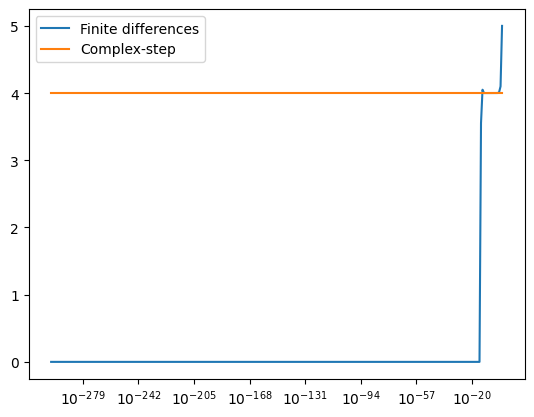

In [17]:
NUM_METHODS = len(METHODS.keys())
for method_id, method_name in enumerate(METHODS.keys()):
    plt.plot(HS, results[method_name], label=method_name.capitalize())
    plt.gca().set_xscale('log')
plt.legend()
plt.show()

Найдём наследственную ошибку нашей функции методом линеаризации, применяя в нём наши  методы оценки производных

In [18]:
def linearization_error_estimate(x: Iterable,
                                 deltas: Iterable,
                                 func: Callable,
                                 derivatives_estimator: Callable,
                                 h: float,
                                 *args) -> float | np.ndarray[float]:
    derivatives = derivatives_estimator(func, x, h, *args)
    A = np.matrix(np.abs(derivatives))
    if A.shape[0] == 1:
        return np.sum(np.multiply(derivatives, deltas))
    else:
        return np.array(A.T @ deltas)[0]

In [19]:
ERROR_PERCENT = 0.1
deltas = np.multiply(X, ERROR_PERCENT / 100)
for method_name, method_function in METHODS.items():
    error = linearization_error_estimate(X, deltas, example_func, method_function, h=10**-10)
    print(f"Linearization error estimate using the {method_name} method is {error}")

Linearization error estimate using the finite differences method is 0.08000000661922967
Linearization error estimate using the complex-step method is 0.07999999999999996


## Task 2

Реализовать классическую интервальную и аффинную арифметику для требуемых в функции $f$ операций. 

Для классической арифметики перегрузим все основные арифметические операции, включая бинарные ($+$, $-$, $\cdot$, $\div$, степень), бинарные с присвоением, унарные и все эти операции в комбинации с обыкновенными числами с обеих сторон (а так же представление при печати). 

In [26]:
class ClassicalInterval:
    def __init__(self, a: int | float, b: int | float = None):
        self.a = a
        if b is not None:
            if b < a:
                raise ValueError("Left boundary should be less than right boundary")
            self.b = b
        else:
            self.b = a
    
    def __repr__(self):
        return f"[{self.a}; {self.b}]"

    def __pos__(self):
        return self

    def __add__(self, o):
        if not isinstance(o, ClassicalInterval):
            o = ClassicalInterval(o)
        return ClassicalInterval(self.a + o.a, self.b + o.b)

    def __radd__(self, o):
        return self + o

    def __iadd__(self, o):
        return self + o
    
    def __neg__(self):
        return ClassicalInterval(-self.b, -self.a)

    def __sub__(self, o):
        return self + (-o)

    def __rsub__(self, o):
        return (-self) - (-o)
    
    def __isub__(self, o):
        return self - o

    def __mul__(self, o):
        if not isinstance(o, ClassicalInterval):
            o = ClassicalInterval(o)
        r = [self.a * o.a, self.a * o.b, self.b * o.a, self.b * o.b]
        return ClassicalInterval(min(r), max(r))
    
    def __rmul__(self, o):
        return self * o
    
    def __imul__(self, o):
        return self * o

    def _inverse(interval):
        if interval.a <= 0 <= interval.b:
            raise ZeroDivisionError("Divider cannot contain zero.")
        r = [1.0 / interval.a, 1.0 / interval.b]
        return ClassicalInterval(min(r), max(r))

    def __truediv__(self, o):
        if not isinstance(o, ClassicalInterval):
            if o == 0:
                raise ZeroDivisionError("Divider cannot be zero.")
            o = ClassicalInterval(o)
        return self * ClassicalInterval._inverse(o)
    
    def __rtruediv__(self, o):
        return o * ClassicalInterval._inverse(self)
    
    def __itruediv__(self, o):
        return self / o
    
    def __pow__(self, o):
        if not isinstance(o, ClassicalInterval):
            o = ClassicalInterval(o)
        r = [self.a ** o.a, self.a ** o.b, self.b ** o.a, self.b ** o.b]
        return ClassicalInterval(min(r), max(r))
    
    def __rpow__(self, o):
        return ClassicalInterval(o) ** self
    
    def abs(self):
        if self.a < 0 and self.b > 0:
            return ClassicalInterval(0, max(-self.a, self.b))
        r = [abs(self.a), abs(self.b)]
        return ClassicalInterval(min(r), max(r))

Попробуем найти ошибку, полученную классической интервальной арифметикой

In [27]:
x_left, x_right = X * (1 - ERROR_PERCENT / 100), X * (1 + ERROR_PERCENT / 100)
classical_error_intervals = [ClassicalInterval(left, right) for left, right in zip(x_left, x_right)]
example_func(classical_error_intervals) - example_func(X)

[-0.07995999999999981; 0.08003999999998967]

В этом примере она оказалась весьма похожей на то, что мы получили линеаризацией, однако это далеко не всегда будет так. Например, в этой функции разница уже заметнее:
$$f(x_1, x_2, \dotsc, x_n) = \sum_{i=1}^n \frac{\frac{1}{x_i^5} + \frac{3^{x_i}}{10} + 1}{x-1}$$

In [76]:
def example_func_2(x: Iterable[float | complex]) -> float:
    return np.sum((1.0 / np.power(x, 5) + np.power(3, x) / 10 + 1) / x - 1)

In [79]:
error_intervals = example_func_2(classical_error_intervals) - example_func_2(X)
print(f"Classical intervals arithmetic got {error_intervals}")
error_linearization = linearization_error_estimate(X, deltas, example_func_2, derivatives_complex_step, 1e-100)
print(f"Linearization with complex step derivatives estimation got {error_linearization}")
print(f"Difference ~{math.ceil(abs(error_intervals.a / error_linearization))} times!")

Classical intervals arithmetic got [-0.02029152619045016; 0.020358588917470666]
Linearization with complex step derivatives estimation got -0.000549989401987016
Difference ~37 times!
